In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error


In [198]:
data = pd.read_excel(r'/Users/murphyk/Volatility Modeling/ECO Surprise Index.xlsx',parse_dates=True,index_col='Date')
data.columns = ['y']
data.dropna(inplace=True)

In [229]:
# Generate features function
def generate_features(df, n=2, degree=2):
    # Ensure the DataFrame is datetime indexed
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame must be datetime indexed")
    
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Pre-allocate space for new columns to avoid fragmentation
    lag_data = {f'lag{lag}': df['y'].shift(lag) for lag in range(1, n + 1)}
    lag_df = pd.DataFrame(lag_data, index=df.index)
    df = pd.concat([df, lag_df], axis=1)
    
    # Time-based Features
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    # Polynomial Features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[['y']])
    poly_df = pd.DataFrame(poly_features, columns=[f'poly{i}' for i in range(1, poly_features.shape[1] + 1)], index=df.index)
    df = pd.concat([df, poly_df], axis=1)
    
    # Drop the first polynomial feature as it is the original feature
    if 'poly1' in df.columns:
        df.drop(['poly1'], axis=1, inplace=True)
    
    # Handle missing values created by shifting
    df = df.bfill()
    
    return df

df = generate_features(data, n=2, degree=2)

# Split into features and target
X = df.drop(columns=['y'])
y = df['y']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

In [232]:
X_train

,lag1,lag2,day_of_week,month,quarter,poly2
Date,,,,,,
2024-08-02,-0.568,-0.568,4,8,3,0.322624
2024-08-01,-0.568,-0.568,3,8,3,0.267289
2024-07-31,-0.517,-0.568,2,7,3,0.215296
2024-07-30,-0.464,-0.517,1,7,3,0.261121
2024-07-29,-0.511,-0.464,0,7,3,0.283024
...,...,...,...,...,...,...
2008-02-08,-0.249,-0.246,4,2,1,0.066049
2008-02-07,-0.257,-0.249,3,2,1,0.050625
2008-02-04,-0.225,-0.257,0,2,1,0.044944


<Axes: xlabel='Date'>

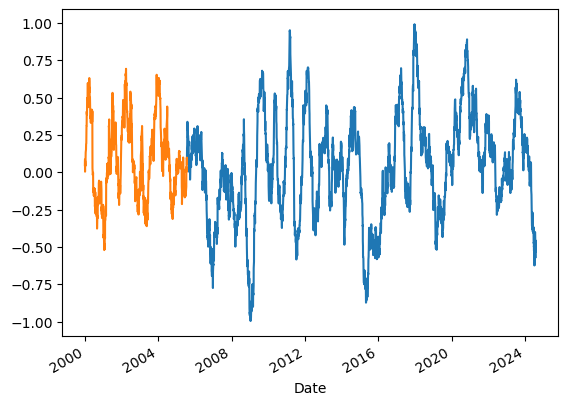

In [216]:
y_train.plot()
y_test.plot()

In [ ]:
# Train XGBoost model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, y_pred_train)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Train Actual')
plt.plot(y_train.index, y_pred_train, label='Train Predictions')
plt.plot(y_test.index, y_test, label='Test Actual')
plt.plot(y_test.index, y_pred_test, label='Test Predictions')
plt.legend()
plt.show()
